# Aadhaar Biometric and Demographic Update Analysis

## Objective
This notebook analyzes Aadhaar biometric and demographic update datasets to uncover
temporal and spatial patterns that differentiate normal identity lifecycle behavior
from statistically anomalous trends.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Data Loading

We load anonymized Aadhaar demographic and biometric update datasets provided by UIDAI.
Each row represents aggregated activity for a pincode on a given date.


In [27]:
demo = pd.read_csv("../data/demographic.csv")
bio = pd.read_csv("../data/biometric.csv")


## Dataset Inspection


In [28]:
demo.head()
bio.head()
demo.shape, bio.shape


((500000, 6), (500000, 6))

## Dataset Integration

We merge the demographic and biometric datasets using common geographic and temporal keys.


In [29]:
df = demo.merge(
    bio,
    on=["date", "state", "district", "pincode"],
    how="inner"
)


## Date Processing

Dates are parsed using Indian date format (DD-MM-YYYY) to preserve chronological accuracy.


In [30]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)


## Aggregation

We aggregate daily activity at the state level to reduce noise and highlight societal patterns.


In [31]:
state_daily = (
    df.groupby(["state", "date"])
      .sum()
      .reset_index()
)


## Feature Engineering

We compute total updates and biometric-to-demographic ratios to normalize population effects.


In [32]:
state_daily["total_demo"] = (
    state_daily["demo_age_5_17"] + state_daily["demo_age_17_"]
)

state_daily["total_bio"] = (
    state_daily["bio_age_5_17"] + state_daily["bio_age_17_"]
)

state_daily["bio_demo_ratio"] = (
    state_daily["total_bio"] / (state_daily["total_demo"] + 1)
)


## Temporal Trend Analysis

Rolling averages help distinguish transient spikes from sustained anomalies.


In [33]:
state_daily["ratio_rolling_14d"] = (
    state_daily
    .groupby("state")["bio_demo_ratio"]
    .rolling(14)
    .mean()
    .reset_index(level=0, drop=True)
)


## Visualization: Time-Series Trends


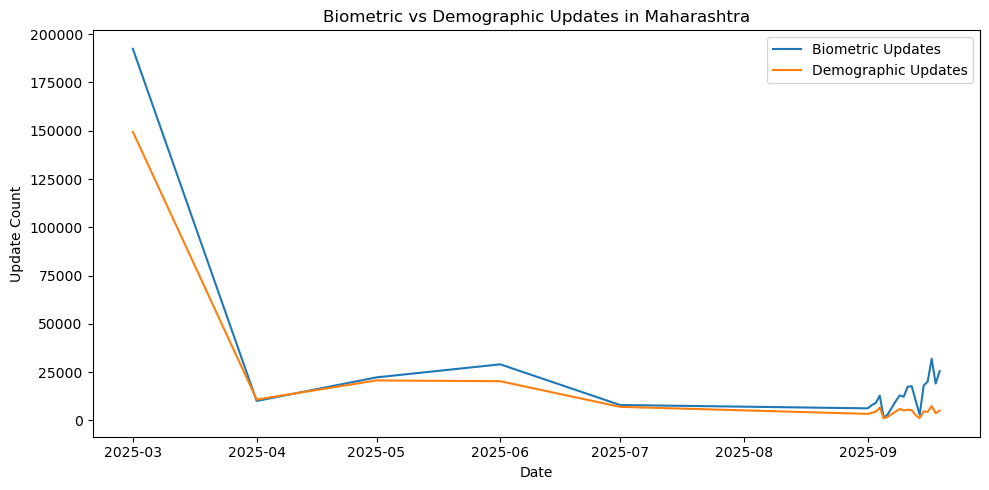

In [34]:
state = "Maharashtra"

subset = state_daily[state_daily["state"] == state]

plt.figure(figsize=(10,5))
plt.plot(subset["date"], subset["total_bio"], label="Biometric Updates")
plt.plot(subset["date"], subset["total_demo"], label="Demographic Updates")
plt.legend()
plt.title(f"Biometric vs Demographic Updates in {state}")
plt.xlabel("Date")
plt.ylabel("Update Count")
plt.tight_layout()
plt.savefig("../plots/time_series.png")
plt.show()


### Interpretation

Sustained biometric dominance without demographic evolution indicates statistically
rare behavior that warrants contextual risk analysis.


# Analysis and Insights

This section performs deeper exploratory and statistical analysis to understand
whether observed biometric–demographic imbalances are random fluctuations or
structural patterns with governance implications.


## Distribution of Biometric-to-Demographic Ratios

We analyze the distribution of update ratios to understand what constitutes
normal versus extreme behavior across regions.


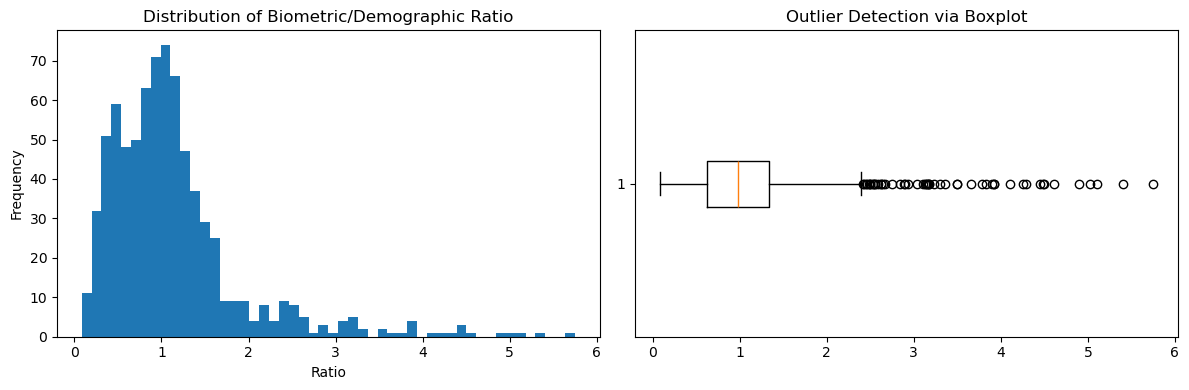

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(state_daily["bio_demo_ratio"], bins=50)
plt.title("Distribution of Biometric/Demographic Ratio")
plt.xlabel("Ratio")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.boxplot(state_daily["bio_demo_ratio"], vert=False)
plt.title("Outlier Detection via Boxplot")

plt.tight_layout()
plt.show()


## Percentile-Based Risk Interpretation
We compute the 90th, 95th, and 99th percentiles of the daily biometric-to-demographic update ratio to quantify how rare certain update patterns are.

In [36]:
percentiles = state_daily["bio_demo_ratio"].quantile(
    [0.90, 0.95, 0.99]
)

percentiles


0.90    2.000000
0.95    2.624807
0.99    4.464152
Name: bio_demo_ratio, dtype: float64

In [37]:
state_daily[state_daily["bio_demo_ratio"] > percentiles.loc[0.99]].head()


,state,date,district,pincode,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,total_demo,total_bio,bio_demo_ratio,ratio_rolling_14d
139,Dadra and Nagar Haveli,2025-04-01,Dadra and Nagar Haveli,396230,78,483,1043,1549,561,2592,4.612100,NaN
141,Dadra and Nagar Haveli,2025-09-02,Dadra and Nagar Haveli,396193,0,1,6,3,1,9,4.500000,NaN
363,Ladakh,2025-09-18,KargilLeh,388215,0,3,22,1,3,23,5.750000,NaN
418,Maharashtra,2025-09-16,AhmadnagarAhmadnagarAhmadnagarAhmadnagarAhmadn...,150535802,556,3932,14256,5857,4488,20113,4.480508,2.615504
420,Maharashtra,2025-09-18,PunePunePunePunePunePunePunePunePunePunePunePu...,139898719,496,3246,13429,5665,3742,19094,5.101256,2.998979


## Persistence Analysis

Anomalies are meaningful only if they persist.
We measure how long elevated ratios remain above normal levels in the states that have high ratio.


In [38]:
threshold = percentiles.loc[0.95]

state_daily["high_ratio_flag"] = (
    state_daily["bio_demo_ratio"] > threshold
)

persistence = (
    state_daily.groupby("state")["high_ratio_flag"]
    .sum()
    .sort_values(ascending=False)
)

persistence.head(10)


state
Maharashtra               8
Dadra and Nagar Haveli    6
Pondicherry               6
Rajasthan                 4
Ladakh                    3
Mizoram                   3
Daman and Diu             3
Puducherry                2
Nagaland                  2
Lakshadweep               1
Name: high_ratio_flag, dtype: int64

## Age-Group Behavioral Decomposition

We analyze whether anomalies are driven by child transitions (5–17)
or adult biometric activity (17+).


In [39]:
state_daily["child_bio_share"] = (
    state_daily["bio_age_5_17"] / (state_daily["total_bio"] + 1)
)

state_daily["adult_bio_share"] = (
    state_daily["bio_age_17_"] / (state_daily["total_bio"] + 1)
)

state_daily[["child_bio_share", "adult_bio_share"]].describe()


,child_bio_share,adult_bio_share
count,764.000000,764.000000
mean,0.462862,0.509088
std,0.167003,0.165590
min,0.000000,0.000000
25%,0.372135,0.414604
50%,0.455004,0.527881
75%,0.556405,0.610110
max,0.938776,0.870588


## Correlation Between Biometric and Demographic Activity

Healthy systems exhibit correlated update behavior.
Decorrelation may signal operational or access issues.


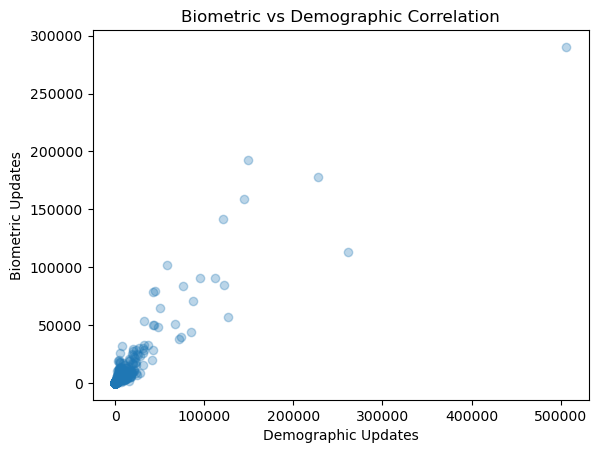

In [40]:
state_daily[["total_bio", "total_demo"]].corr()
plt.scatter(state_daily["total_demo"], state_daily["total_bio"], alpha=0.3)
plt.xlabel("Demographic Updates")
plt.ylabel("Biometric Updates")
plt.title("Biometric vs Demographic Correlation")
plt.show()


## Key Analytical Insight

We observe that while biometric and demographic updates are generally correlated,
a small subset of regions exhibit persistent, high biometric dominance with
minimal demographic evolution.

Such behavior violates expected identity lifecycle patterns and
warrants contextual, risk-based attention rather than rule-based flagging.


## From Analysis to Solution

These findings motivate an AI-based contextual risk engine that:
- Learns normal temporal behavior
- Accounts for spatial locality
- Distinguishes lifecycle events from structural anomalies
- Produces interpretable risk scores instead of binary flags


## Conclusion

This analysis demonstrates that meaningful societal and administrative insights
can be extracted from aggregated Aadhaar update data.
By modeling identity behavior over time and space, we enable proactive,
privacy-preserving governance interventions.
